# **Recurrent Neural Network - Analyse de sentiments**

Le but de cet exercice est la classification binaire (positive ou négative) de reviews en utilisant un RNN sur un dataset de commentaires IMDB que vous trouverez dans le dossier data.

In [165]:
# import des librairies
import string
from collections import Counter
import pandas as pd
import numpy as np

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

## **1. Import des données et preprocessing**

1. Importer les 2 fichiers ".txt" de data/imdb
2. Vérifier ce qu'il y a dedans si c'est pas déjà fait...
3. Un peu de preprocessing de texte, allez on va chercher dans sa petite mémoire et sinon dans son gros ordinateur :
>- convertir en minuscules
>- retirer la ponctuation
>- créer une liste des reviews et déterminer combien il y en a. Pareil pour les labels. Inch'Allah y en aura autant.

In [2]:
# import des txt
with open('data/imdb/reviews.txt', 'r') as f:
    reviews_str = f.read()
with open('data/imdb/labels.txt', 'r') as f:
    labels_str = f.read()

In [3]:
# reviews
type(reviews_str), len(reviews_str), reviews_str[:150]

(str,
 33678267,
 'bromwell high is a cartoon comedy . it ran at the same time as some other programs about school life  such as  teachers  . my   years in the teaching ')

In [4]:
# labels
type(labels_str), len(labels_str), labels_str[:150]

(str,
 225000,
 'positive\nnegative\npositive\nnegative\npositive\nnegative\npositive\nnegative\npositive\nnegative\npositive\nnegative\npositive\nnegative\npositive\nnegative\npositi')

In [5]:
# netoyage des string
reviews_str = reviews_str.lower()
reviews_str = reviews_str.translate(str.maketrans('', '', string.punctuation))

In [18]:
# split et nb de lables
rvws = reviews_str.splitlines()
labs = labels_str.splitlines()
len(rvws), len(labs)

(25000, 25000)

## **2. Tokenisation ou encodage**

Le but est de remplacer les mots des reviews par des entiers. Si vous voulez faire à votre sauce, vous y êtes encouragés !

Sinon, les quelques étapes décrites ci-dessous vous permettront de le faire :
>- compter l'ensemble des mots (vous pouvez utiliser `Counter` de la librairie `collections` qui est une des plus rapide dans ce domaine)
>- les trier par ordre décroissant d'occurrences
>- créer un dictionnaire `word_mapping` où les clés sont les mots et les valeurs l'entier associé (votre dico doit être `{'the': 1, 'and': 2, 'a': 3, 'of': 4,..., 'muppified': 74070, 'whelk': 74071, 'hued': 74072}}`). C'est volontaire que ça commence à 1 car on utilisera le "0" comme caractère spécial (il servira pour "remplir" les reviews les plus courtes afin qu'elles aient toutes la même taille...)
>- encoder les mots (c'est-à-dire les remplacer par l'entier qui les représente)
>- encoder les labels (ça c'est fastoche, on se débrouille)

In [19]:
# comptage des mots et tri par occurrence
words = reviews_str.split()
countwords = Counter(words)
sorted_words = sorted(countwords, key=countwords.get, reverse=True)

In [20]:
# dictionnaire de correspondance mot=entier
word_mapping = {w:i+1 for i,w in enumerate(sorted_words)}

In [21]:
# encodage des mots dans les reviews
rvws_num = [list(map(lambda w : word_mapping[w], rvw.split())) for rvw in rvws]
print(rvws_num[:2])

[[21025, 308, 6, 3, 1050, 207, 8, 2138, 32, 1, 171, 57, 15, 49, 81, 5785, 44, 382, 110, 140, 15, 5194, 60, 154, 9, 1, 4975, 5852, 475, 71, 5, 260, 12, 21025, 308, 13, 1978, 6, 74, 2395, 5, 613, 73, 6, 5194, 1, 24103, 5, 1983, 10166, 1, 5786, 1499, 36, 51, 66, 204, 145, 67, 1199, 5194, 19869, 1, 37442, 4, 1, 221, 883, 31, 2988, 71, 4, 1, 5787, 10, 686, 2, 67, 1499, 54, 10, 216, 1, 383, 9, 62, 3, 1406, 3686, 783, 5, 3483, 180, 1, 382, 10, 1212, 13583, 32, 308, 3, 349, 341, 2913, 10, 143, 127, 5, 7690, 30, 4, 129, 5194, 1406, 2326, 5, 21025, 308, 10, 528, 12, 109, 1448, 4, 60, 543, 102, 12, 21025, 308, 6, 227, 4146, 48, 3, 2211, 12, 8, 215, 23], [63, 4, 3, 125, 36, 47, 7472, 1395, 16, 3, 4181, 505, 45, 17, 3, 622, 134, 12, 6, 3, 1279, 457, 4, 1721, 207, 3, 10624, 7373, 300, 6, 667, 83, 35, 2116, 1086, 2989, 34, 1, 898, 46417, 4, 8, 13, 5096, 464, 8, 2656, 1721, 1, 221, 57, 17, 58, 794, 1297, 832, 228, 8, 43, 98, 123, 1469, 59, 147, 38, 1, 963, 142, 29, 667, 123, 1, 13584, 410, 61, 94, 177

In [22]:
# encodage des labels
labs_num = [1*(lab == 'positive') for lab in labs]
labs_num[:2]

[1, 0]

## **3. Longueur des séquences**

Il s'agit ici d'analyser la longueur des reviews pour déterminer éventuellement des outliers et choisir ce qu'on en fait. On va aussi "uniformiser" la longueur des séquence.

1. Avec la méthode de votre choix (graphique, stats desc...), étudier la longueur des reviews
2. Déterminer s'il y a des outliers et ce que vous souhaitez en faire (si vous les décidez de les supprimer, attention de bien supprimer aussi les labels correspondants...)
3. Ça a été évoqué un peu plus haut, on veut que nos reviews aient toutes la même taille pour faciliter l'entraînement du réseau. Par conséquent on va ajouter des 0 aux reviews les plus courtes et tronquer les reviews les plus longues (*padding/truncating*, si vous vous souvenez bien on a vu il y a peu le *zero-padding* dans un certain cas...bon ben c'est pareil).  
>- définir une fonction `trunc_pad(review_list, length)` :
>>- qui prend en paramètres la liste des reviews (chaque review étant encodée en une liste d'entiers) et une longueur donnée
>>- et qui retourne un array 2D avec (en ligne) les reviews trop longues tronquées et des 0 à gauche pour les reviews trop courtes. Avant de vous lancer et pour vous assurer d'avoir compris, quelles dimensions doit avoir votre array en sortie ?
>>- tester votre fonction avec une longueur fixée à 250 et afficher les 5 premières valeurs des 5 premières reviews. Vous devez obtenir ça:  
\[[    0     0     0     0     0]  
[    0     0     0     0     0]  
[22382    42 46418    15   706]  
[ 4505   505    15     3  3342]  
[    0     0     0     0     0]\]
>- maintenant, que c'est fait, je peux vous le dire, il y a une fonction dans `keras.preprocessing` qui permet de le faire. La trouver et comparer les temps d'éxecution des 2 fonctions.

count    25000.00000
mean       240.80784
std        179.01773
min         10.00000
25%        130.00000
50%        179.00000
75%        293.00000
max       2514.00000
dtype: float64

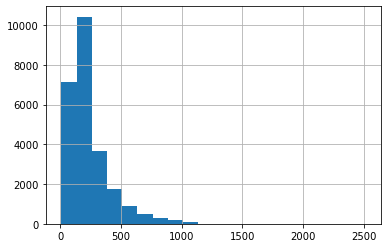

In [23]:
# la longueur des reviews
rvws_len = pd.Series((map(len, rvws_num)))
rvws_len.hist(bins=20);
rvws_len.describe()

In [69]:
# longueur des séquences
seq_len = 250

In [70]:
# fonction padding/truncating
def trunc_pad(review_list=rvws_num, length=300):
    out = np.zeros((len(review_list), length), dtype=int)
    for i, rvw in enumerate(review_list):
        out[i,-len(rvw):] = rvw[:length]
        
    return out

In [71]:
# test
trunc_pad(length=seq_len)[:5, :]

array([[    0,     0,     0, ...,     8,   215,    23],
       [    0,     0,     0, ...,    29,   108,  3324],
       [22382,    42, 46418, ...,    13,   391,    22],
       [ 4505,   505,    15, ...,   108,    37,   227],
       [    0,     0,     0, ...,     6,   179,   395]])

In [72]:
%%time
X0 = pad_sequences(rvws_num, maxlen=seq_len, truncating='post')

CPU times: user 288 ms, sys: 3.8 ms, total: 291 ms
Wall time: 289 ms


In [73]:
%%time
X = trunc_pad(review_list=rvws_num, length=seq_len)

CPU times: user 269 ms, sys: 7.64 ms, total: 276 ms
Wall time: 274 ms


## **4. Échantillons d'entraînement, de validation et de test**

Découper les données en train, validation et test sets de la manière qui vous plaira. Tant que c'est juste et cohérent bien sûr.  
Il faut qu'il y ait 20000 observations dans le train, 2500 dans le validation et 2500 dans le test. 

In [133]:
y = np.array(labs_num)
X.shape, y.shape

((25000, 250), (25000,))

In [134]:
%%time
# méthode sklearn
X_tmp, X_test, y_tmp, y_test = train_test_split(X, y, test_size=2500)
X_train, X_val, y_train, y_val = train_test_split(X_tmp, y_tmp, test_size=2500)

CPU times: user 29.1 ms, sys: 4.6 ms, total: 33.7 ms
Wall time: 31.3 ms


In [135]:
%%time
# on peut le faire "à la main" aussi mais ne pas oublier de mélanger les données
idx_shuffled = np.arange(25000)
np.random.shuffle(idx_shuffled)
X_shuffled = X[idx_shuffled]
y_shuffled = y[idx_shuffled]

nb_tr, nb_val = 20000, 2500
X_train, X_val, X_test = X_shuffled[:nb_tr], X_shuffled[nb_tr:nb_tr+nb_val], X_shuffled[nb_tr+nb_val:]
y_train, y_val, y_test = y_shuffled[:nb_tr], y_shuffled[nb_tr:nb_tr+nb_val], y_shuffled[nb_tr+nb_val:]

CPU times: user 14.4 ms, sys: 4.29 ms, total: 18.7 ms
Wall time: 16.4 ms


In [136]:
# on check les shapes
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(20000, 250) (2500, 250) (2500, 250)
(20000,) (2500,) (2500,)


## **5. Petite paranthèse sur le _word embedding_**

Le [*word embedding*](https://fr.wikipedia.org/wiki/Word_embedding) consiste à transformer des mots sous forme de vecteurs de nombres. Bon ça on peut le faire relativement facilement, vous venez d'ailleurs de le faire avec la représentation du lexique des reviews en nombres entiers. Pour passer à un vecteur il suffirait juste de faire un one-hot-encoding.

Il y a plusieurs problèmes à cette solution (même si on l'utilise parfois dans du NLP simple) :
- la dimension de l'espace engendré
- l'absence totale de notion de similarité (avec la représentation one-hot, 2 mots qui n'ont rien à voir sont aussi différents que 2 mots tout à fait synonyme)
- le fait que les vecteurs contiennent quasiment que des 0 (sparse matrix)
- le fait que les modèles sont ensuite difficilement généralisable car en cas de nouveau mot, le modèle ne sait pas du tout les traiter puisqu'il ne peut pas du tout les comparer aux mots vus dans l'entraînement

Donc le *word embedding* s'attaque à ce problème avec pour objectifs de :
1. représenter les mots sous forme de vecteurs de nombres réels (et non entiers, on passe donc à un espace continu et plus discret)
2. conserver la notion de similarité c'est-à-dire que 2 vecteurs qui sont proches doivent représenter des mots "sémantiquement proches"
3. de les représenter dans un espace de plus petite dimension (en fonction de votre vocabulaire, soit le nombre de mots dans votre problème, ça peut aller très vite, généralement plusieurs milliers ou 10aines de milliers)

Le principe est de s'intéresser au contexte des mots, c'est-à-dire, quels mots sont associés ensemble en s'appuyant sur la co-occurrence.
Différents modèles de word embedding existent : [word2vec](https://fr.wikipedia.org/wiki/Word2vec), Glove, fasttext...

En pratique avec `keras`, que se passe-t-il lorsqu'on ajout une couche [*embedding*](https://keras.io/api/layers/core_layers/embedding/) ? Un exemple juste en dessous.

Un peu de visionnage pour y voir plus clair si ça vous intéresse :
- https://www.youtube.com/watch?v=Eku_pbZ3-Mw
- https://www.youtube.com/watch?v=oUpuABKoElw
- https://www.youtube.com/watch?v=5PL0TmQhItY

Et un peu de lecture :
- https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/
- https://towardsdatascience.com/why-do-we-use-embeddings-in-nlp-2f20e1b632d2
- https://towardsdatascience.com/word-embeddings-for-nlp-5b72991e01d4
- https://proceedings.neurips.cc/paper/2013/file/9aa42b31882ec039965f3c4923ce901b-Paper.pdf
- https://medium.com/rasa-blog/supervised-word-vectors-from-scratch-in-rasa-nlu-6daf794efcd8
- https://web.stanford.edu/~jurafsky/slp3/6.pdf

In [156]:
# on prend quelques phrases d'exemples pour illustrer le word embedding
t1 = "i hope to see you again"
t2 = "you wish to see me soon"
t3 = "i wish we will meet again"

In [157]:
# méthode mise en place au dessus
cnts = Counter(' '.join([t1,t2,t3]).split())
dico = {w:i+1 for i,w in enumerate(sorted(cnts, key=cnts.get, reverse=True))}
dico, len(dico)

({'i': 1,
  'to': 2,
  'see': 3,
  'you': 4,
  'again': 5,
  'wish': 6,
  'hope': 7,
  'me': 8,
  'soon': 9,
  'we': 10,
  'will': 11,
  'meet': 12},
 12)

In [158]:
# en représentant les vecteurs avec cette méthode on obtient
t_num = [[dico[w] for w in t.split()] for t in [t1, t2, t3]]
t_num

[[1, 7, 2, 3, 4, 5], [4, 6, 2, 3, 8, 9], [1, 6, 10, 11, 12, 5]]

In [161]:
# on crée un modèle avec un couche embedding
mod_emb = Sequential()
mod_emb.add(Embedding(input_dim=13, output_dim=2, input_length=6))
mod_emb.compile()
print(mod_emb.summary())

out1 = mod_emb.predict([t_num[0]])
out2 = mod_emb.predict([t_num[1]])
out3 = mod_emb.predict([t_num[2]])

print(out1, out2, out3)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 6, 2)              26        
Total params: 26
Trainable params: 26
Non-trainable params: 0
_________________________________________________________________
None
[[[ 1.21878982e-02 -2.65855677e-02]
  [ 2.03719474e-02  8.20383430e-05]
  [ 3.71456854e-02 -9.21390206e-03]
  [ 2.59860642e-02  1.91943385e-02]
  [ 1.03757605e-02 -2.71544456e-02]
  [ 3.49335335e-02  2.88656987e-02]]] [[[ 0.01037576 -0.02715445]
  [ 0.03473543 -0.01919251]
  [ 0.03714569 -0.0092139 ]
  [ 0.02598606  0.01919434]
  [-0.00295806  0.04078201]
  [-0.03978165 -0.02091659]]] [[[ 0.0121879  -0.02658557]
  [ 0.03473543 -0.01919251]
  [-0.02161729  0.04306128]
  [-0.01042342  0.01372781]
  [ 0.00705602  0.00491847]
  [ 0.03493353  0.0288657 ]]]


## **6. Création, entraînement et évaluation du modèle**

Créer un premier modèle, que vous serez tout à fait libre et même cordialement conviés à améliorer par la suite, avec :
- une couche Embedding
- une couche LSTM

In [167]:
model=Sequential()

model.add(Embedding(input_dim=len(word_mapping)+1, output_dim=64, input_length=seq_len))
model.add(LSTM(units=100))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 250, 64)           4740672   
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 4,806,773
Trainable params: 4,806,773
Non-trainable params: 0
_________________________________________________________________


In [168]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=3)

Epoch 1/3
625/625 [==============================] - 78s 125ms/step - loss: 0.4852 - accuracy: 0.7612 - val_loss: 0.4593 - val_accuracy: 0.8352
Epoch 2/3
625/625 [==============================] - 75s 120ms/step - loss: 0.2712 - accuracy: 0.8961 - val_loss: 0.3398 - val_accuracy: 0.8632
Epoch 3/3
625/625 [==============================] - 76s 121ms/step - loss: 0.1441 - accuracy: 0.9497 - val_loss: 0.3703 - val_accuracy: 0.8660


In [ ]:
scores = model.evaluate(X_test, y_test, verbose=0)
print(f'Accuracy: {scores[1]}')

Accuracy: 0.8763999938964844
